## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [53]:
# Generate synthetic dataset
np.random.seed(0)
N = 10000
M = 10
K = 2
EDGE_PROB=0.5
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [54]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [65]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=16384
)

# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Computing O^{-1}...
Estimating Z...
[Epoch 0] Loss: 3605909.500000
[Epoch 5000] Loss: 416.928040
[Epoch 10000] Loss: 403.801788
[Epoch 15000] Loss: 387.808350
[Epoch 20000] Loss: 364.217743
[Epoch 25000] Loss: 357.359253
[Epoch 30000] Loss: 355.978180
[Epoch 35000] Loss: 354.711853
[Epoch 40000] Loss: 352.656342
[Epoch 45000] Loss: 346.547180
[Epoch 49999] Loss: 317.219574
Estimating \mu...
[Epoch 0] Loss: 186.242126
[Epoch 5000] Loss: 0.023695
[Epoch 10000] Loss: 0.005299
[Epoch 15000] Loss: 0.001262
[Epoch 20000] Loss: 0.000309
[Epoch 25000] Loss: 0.000077
[Epoch 30000] Loss: 0.000020
[Epoch 35000] Loss: 0.000006
[Epoch 40000] Loss: 0.000002
[Epoch 45000] Loss: 0.000001
[Epoch 49999] Loss: 0.000001
Average absolute error: 0.04522342837581881


### Sanity check that the true $Z$ gets lower loss

In [66]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

10954013.818901306

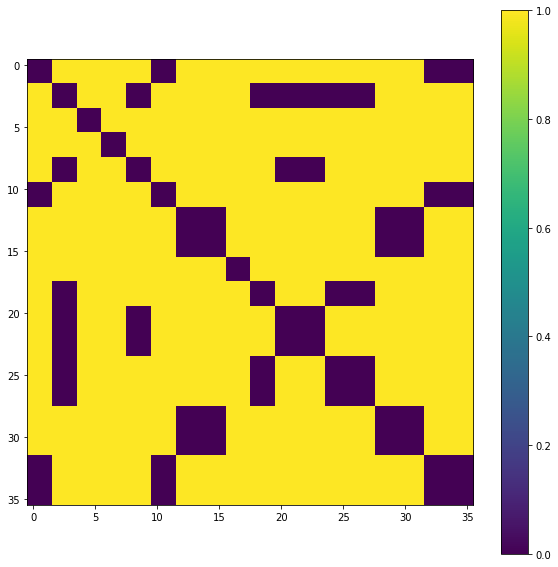

In [67]:
visualize_matrix(mask)

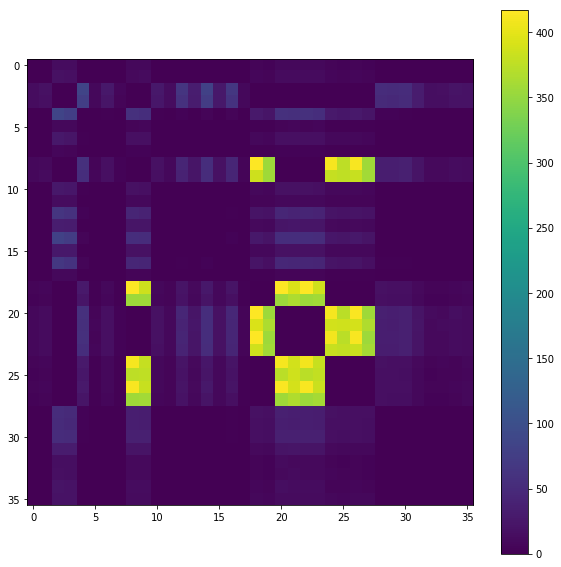

In [68]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

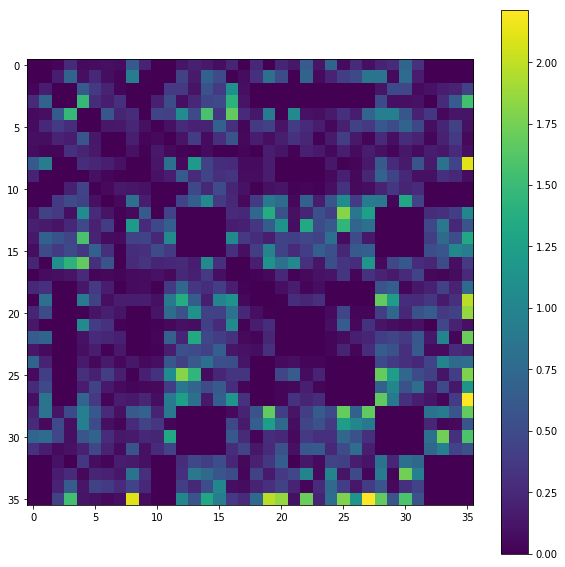

In [69]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)

def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]